# Stochastic Simulation of Gene Circuits


In [1]:
import multiprocessing

# NumPy and odeint, our workhorses
import numpy as np
import scipy.stats as st
import numba

# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# Line profiler (you might not have this installed)
# %load_ext line_profiler

# This is to enable inline displays for the purposes of the tutorial
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

ModuleNotFoundError: No module named 'numba'

#  The Dynamical Equations

For simple transcription, we have the following reactions.

\begin{align}
\text{DNA} \rightarrow \text{mRNA} 
\end{align}

# Macroscale equations

As we've seen before, the deterministic dynamics, which describe mean concentrations over a large population of cells, are described by the ODEs

\begin{align}
\frac{\mathrm{d}m}{\mathrm{d}t} &= \beta_m - \gamma_m m, \\[1em]
\frac{\mathrm{d}p}{\mathrm{d}t} &= \beta_p m - \gamma_p p,
\end{align}

We assume that the production rates of mRNA and protein are constants.  We nondimensionalize time using $\gamma_m$ and rename parameters/variables

\begin{align}
&\beta_m/\gamma_m \to \beta_m, \\[1em]
&\beta_p/\gamma_m \to \beta_p, \\[1em]
&\gamma_m t \to t.
\end{align}

The dimensionless equations are

\begin{align}
\frac{\mathrm{d}m}{\mathrm{d}t} &= \beta_m - m, \\[1em]
\frac{\mathrm{d}p}{\mathrm{d}t} &= \beta_p m - \gamma p,
\end{align}

with $\gamma = \gamma_p/\gamma_m$.

### The Master equation

We can write a master equation for these dynamics.  In this case, each state is defined by an mRNA copy number $m$ and a protein copy number $p$.  So, we will write a master equation for $P(m,p,t)$.

\begin{align}
\frac{\mathrm{d}P(m,p,t)}{\mathrm{d}t} &= \beta_m P(m-1,p,t) + (m+1)P(m+1,p,t) - \beta_m P(m,p,t) - mP(m,p,t) \\[1em]
&+\beta_p mP(m,p-1,t) + \gamma_p (p+1)P(m,p+1,t) - \beta_p mP(m,p,t) - \gamma p P(m,p,t).
\end{align}

As in lecture, we have implicitly defined $P(m,p,t) = 0$ if $m < 0$ or $p< 0$.
This is the master equation we will sample from using the stochastic simulation algorithm (SSA) or Gillespie algorithm.

## The Gillespie algorithm

The transition probabilities are also called **propensities** in the context of stochastic simulation.  To cast this problem for a Gillespie simulation, we can write each change of state (moving either the copy number of mRNA or protein up or down by 1 in this case) and their respective propensities.

\begin{align}
\begin{array}{ll}
\text{reaction, }r_i & \text{propensity, } a_i \\
m \rightarrow m+1,\;\;\;\; & \beta_m \\[0.3em]
m \rightarrow m-1, \;\;\;\; & m\\[0.3em]
p \rightarrow p+1, \;\;\;\; & \beta_p m \\[0.3em]
p \rightarrow p-1, \;\;\;\; & \gamma p.
\end{array}
\end{align}

We won't carefully prove that the Gillespie algorithm samples from the probability distribution governed by the master equation, but will state the principles behind it.  The basic idea is that events (such as those outlined above) are rare, discrete, separate events.  I.e., each event is a Poisson process.  The Gillespie algorithm starts with some state, as $(m_0,p_0)$.  Then a state change, *any* state change, will happen in some time $\Delta t$ that has a certain probability distribution (which we will show is exponential momentarily).  The probability that the state change that happens is a reaction $j$ is proportional to $a_j$.  That is to say, state changes with high propensities are more likely to occur.  Thus, choosing which of the $n$ state changes happens in $\Delta t$ is just a matter of drawing an integer $j$ in $[1,n]$ where the probability of drawing $j$ is \left.a_j\middle/\sum_i a_i\right.$.

Now, how do we determine how long the state change took?  The probability that a *given* state change $i$ takes place in time $\Delta t$ is

\begin{align}
P(\Delta t\mid \lambda_i) = \lambda \mathrm{e}^{-\lambda t},
\end{align}

since the time it takes for arrival of a Poisson process is exponentially distributed.

The probability that it *hasn't* arrived in time $\Delta t$ is the probability that the arrival time is greater than $\Delta t$.

\begin{align}
P(t > \Delta t\mid \lambda_i) = \int_{\Delta t}^\infty \mathrm{d}t\,P(t\mid \lambda_i) = \mathrm{e}^{-\lambda_i \Delta t}.
\end{align}

Now, say we have $n$ processes that arrive in time $\Delta t_1, \Delta t_2, \ldots$.  The probability that *none* of them arrive before $\Delta t$ is

\begin{align}
P(\Delta t_1 > \Delta t, P(\Delta t_2 > \Delta t, \ldots) &=
P(\Delta t_2 > \Delta t) P(\Delta t_2 > \Delta t) \cdots =
\prod_i \mathrm{e}^{\lambda_i \Delta t} \\[1em]
&= \mathrm{exp}\left[\left(\sum_i \lambda_i \Delta t \right)\Delta t\right].
\end{align}

This is the same as the probability of a single Poisson process with $\lambda = \sum_i \lambda_i$ not arriving before $\Delta t$.  So, the probability that it does arrive in $\Delta t$ is exponentially distributed with mean $\left(\sum_i \lambda\right)^{-1}$ (since the mean of an exponential distribution is $1/\lambda$).

So, we know how to choose a state change and we also know how long it takes.
The Gillespie algorithm then proceeds as follows.

>1. Choose an initial condition, e.g. $m = p = 0$.
2. Calculate the propensity for each of the enumerated state changes.  The propensities may be functions of $m$ and $p$, so they need to be recalculated for every $m$ and $p$ we encounter.
3. Choose how much time the reaction will take by drawing out of an exponential distribution with a mean equal to $\left.1\middle/\sum_i a_i\right.$.  This means that the time required for a change arises from a Poisson process.
4. Choose what state change will happen by drawing a sample over the discrete distribution where $P_i = \left.a_i\middle/\left(\sum_i a_i\right)\right.$.  In other words, the probability that a state change will be chosen is proportional to its propensity.
5. Increment time by the time step you chose in step 3.
6. Update the states according to the state change you choose in step 4.
7. If $t$ is less than your pre-determined stopping time, go to step 2.

Gillespie proved that this algorithm samples the probability distribution described by the master equation in his seminal papers in 1976 and 1977.  I recommend reading D. T. Gillespie, *J. Phys. Chem.*, **81**, 2340-2361, 1977.  You can also read a concise discussion of how the algorithm samples the master equation in section 4.2 of Del Vecchio and Murray.

## Coding up the Gillespie simulation

To code up the Gillespie simulation, we first make an an array that gives the changes in the counts of $m$ and $p$ for each of the four reactions.  This is a way of encoding the updates in the particle counts that we get from choosing the respective state changes.

In [1]:
# Column one corresponds to gene off, column 2 corresponds to gene on, and column 3 corresponds to mRNA
simple_update = np.array([[-1, 1, 0],
                          [1, -1, 0],
                          [0, 0, 1],
                          [0, 0, -1]], dtype=np.int)

NameError: name 'np' is not defined

Next, we make a function that returns an array of propensities for each of the four reactions.

In [27]:
def simple_propensity(params, population):
    """
    Returns an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack parameters
    k_12, k_21, k_t, gamma = params
    
    # Unpack population
    g_off, g_on, m = population
    
    return np.array([k_12, 
                     k_21, 
                     k_t, 
                     gamma * m])

### Making a draw

Finally, we write a general function that draws a choice of reaction and the time interval for that reaction.  This is the heart of the Gillespie algorithm, so we will take some time to discuss speed.  First, to get the time interval, we sample a random number from an exponential distribution with mean $\left(\sum_i a_i\right)^{-1}$.  This is easily done using the `np.random.exponential()` function.  

Next, we have to select which reaction will take place.  This amounts to drawing a sample over the discrete distribution where $P_i = a_i\left(\sum_i a_i\right)^{-1}$, or the probability of each reaction is proportional to its propensenity.  This can be done using `scipy.stats.rv_discrete`, which allows specification of an arbitrary discrete distribution.  We will write a function to do this.

In [28]:
def sample_discrete(probs):
    """
    Randomly sample an index with probability given by probs.
    """
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

In [29]:
# Function to draw time interval and choice of reaction
def gillespie_draw(params, propensity_func, population):
    """
    Draws a reaction and the time it took to do that reaction.
    """
    # Compute propensities
    props = propensity_func(params, population)
    
    # Sum of propensities
    props_sum = props.sum()
    
    # Compute time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = props / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time

## SSA time stepping

Now we are ready to write our main SSA loop.  We will only keep the counts at pre-specified time points.  This saves on RAM, and we really only care about the values at given time points anyhow.

In [30]:
def gillespie_ssa(params, propensity_func, update, population_0, 
                  time_points):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from proability distribution of particle counts over time.
    
    Parameters
    ----------
    params : arbitrary
        The set of parameters to be passed to propensity_func.
    propensity_func : function
        Function of the form f(params, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
        
    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=np.int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(params, propensity_func, population)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out

## Running and parsing results

We can now run a set of SSA simulations and plot the results.  We will run 100 trajectories and store them.  We will use $\beta_p = \beta_m = 10$ and $\gamma = 0.4$.

In [39]:
# Specify parameters for calculation
params = np.array([10, 10, 10, 0.4])
time_points = np.linspace(0, 50, 101)
population_0 = np.array([0, 0, 0])
n_simulations = 100

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
pops = np.empty((n_simulations, len(time_points), 3))

# Run the calculations
for i in range(n_simulations):
    pops[i,:,:] = gillespie_ssa(params, simple_propensity, simple_update,
                                population_0, time_points)

We now have our samples, so we can plot the trajectories.

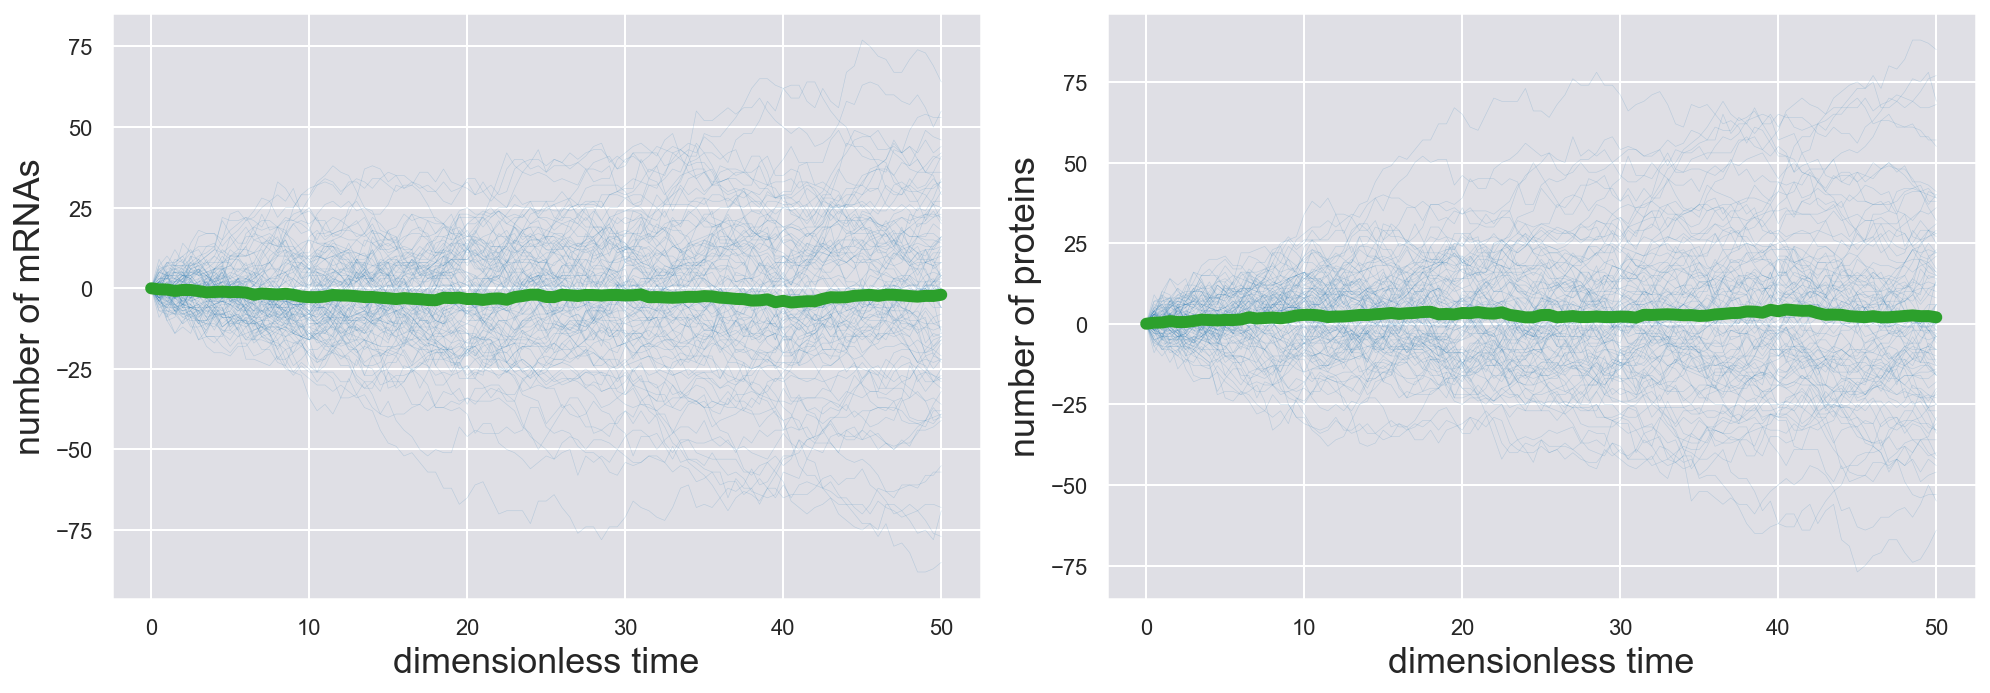

In [41]:
# Set up subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot mRNA trajectories
for i in range(n_simulations):
    ax[0].plot(time_points, pops[i,:,0], '-', lw=0.3, alpha=0.2, 
               color=sns.color_palette()[0])

# Plot mRNA mean
ax[0].plot(time_points, pops[:,:,0].mean(axis=0), '-', lw=6, 
           color=sns.color_palette()[2])

# Plot protein trajectories
for i in range(n_simulations):
    ax[1].plot(time_points, pops[i,:,1], 'k-', lw=0.3, alpha=0.2,
               color=sns.color_palette()[0])

# Plot protein mean
ax[1].plot(time_points, pops[:,:,1].mean(axis=0), 'r-', lw=6, 
           color=sns.color_palette()[2])

# Label axes
ax[0].set_xlabel('dimensionless time')
ax[1].set_xlabel('dimensionless time')
ax[0].set_ylabel('number of mRNAs')
ax[1].set_ylabel('number of proteins')
plt.tight_layout()

We can also compute the steady state properties by considering the last point in our trace. The last 50 time points are at steady state, so we will average over them.

In [43]:
print('mRNA mean copy number =', pops[:,-50:,0].mean())
print('protein mean copy number =', pops[:,-50:,1].mean())
print('mRNA variance =', pops[:,-50:,0].std()**2)
print('protein variance =', pops[:,-50:,1].std()**2)
print('mRNA noise =', pops[:,-50:,0].std() / pops[:,-50:,0].mean())
print('protein noise =', pops[:,-50:,1].std() / pops[:,-50:,1].mean())
print('protein Fano factor =', 
      pops[:,-50:,1].std()**2 / pops[:,-50:,1].mean())
print('mRNA Fano factor =', pops[:,-50:,0].std()**2 / pops[:,-50:,0].mean())
print('protein Fano factor =', 
      pops[:,-50:,1].std()**2 / pops[:,-50:,1].mean())

mRNA mean copy number = -2.75
protein mean copy number = 2.75
mRNA variance = 651.6535
protein variance = 651.6535
mRNA noise = -9.282729008822765
protein noise = 9.282729008822765
protein Fano factor = 236.9649090909091
mRNA Fano factor = -236.9649090909091
protein Fano factor = 236.9649090909091


Finally, we can compute the steady state probability distributions by computing histograms. The theoretical distribution for mRNA is Poisson, which is overlayed in green.

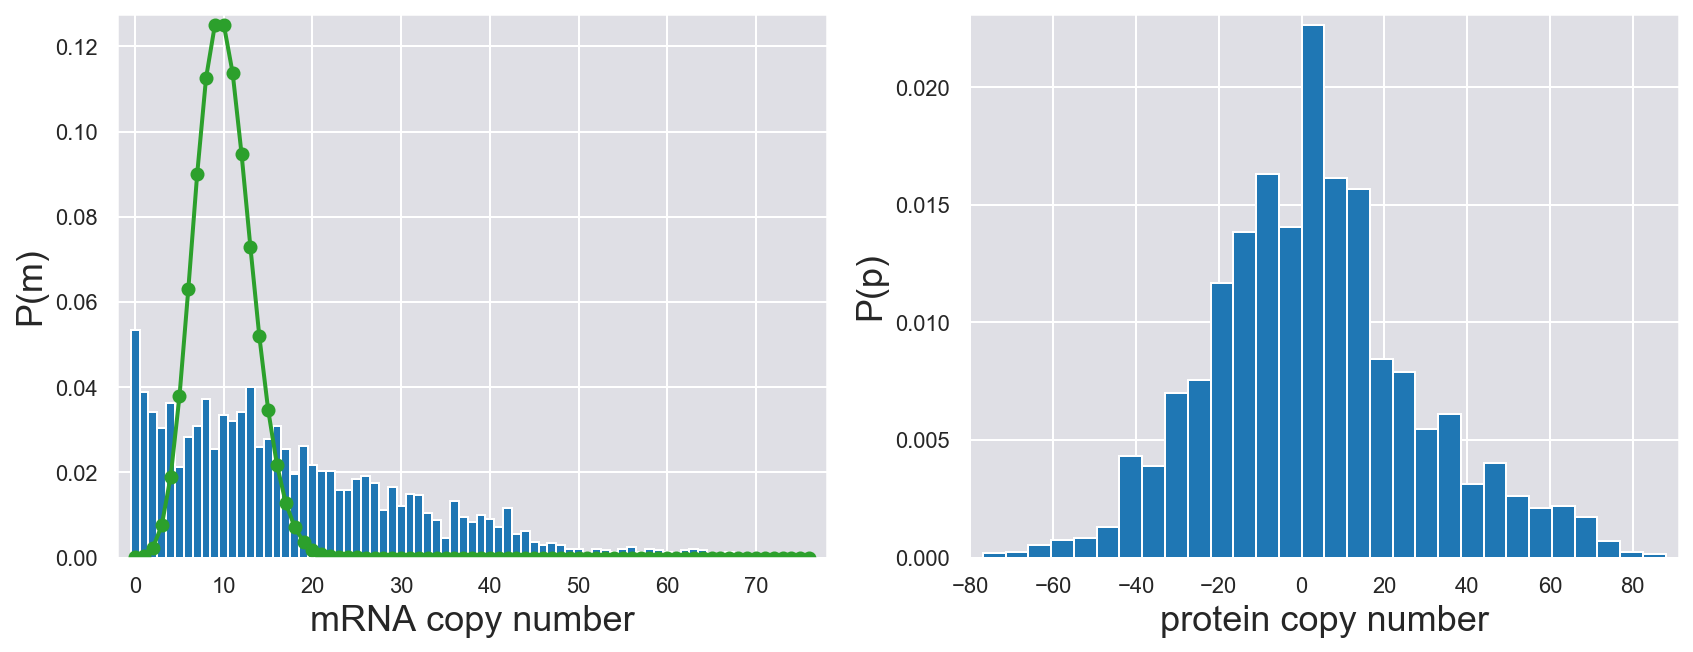

In [45]:
# Set up subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot histogram of mRNA profile with Poisson overlayed
mbins = np.arange(pops[:,-50:,0].max()+1) - 0.5
m = mbins[:-1] + 0.5
ax[0].hist(pops[:,-50:,0].flatten(), mbins, density=True)
ax[0].plot(m, st.poisson.pmf(m, params[0]), '.-', markersize=12, 
           color=sns.color_palette()[2])
ax[0].set_xlabel('mRNA copy number')
ax[0].set_ylabel('P(m)')
ax[0].margins(0.02)

# Plot histogram of protein profile
ax[1].hist(pops[:,-50:,1].flatten(), bins=30, density=True)
ax[1].set_xlabel('protein copy number')
ax[1].set_ylabel('P(p)')
ax[1].margins(0.02)